# Deep Learning with Julia

## Housing Data

First and foremost, import the libraries we need.

In [1]:
using Flux, Flux.Tracker
using FFTW
using Colors
using Images
using Base.Iterators: repeated

INFO: Recompiling stale cache file /Users/ranjan/.julia/lib/v0.6/Flux.ji for module Flux.
INFO: Recompiling stale cache file /Users/ranjan/.julia/lib/v0.6/Colors.ji for module Colors.
INFO: Recompiling stale cache file /Users/ranjan/.julia/lib/v0.6/IntervalSets.ji for module IntervalSets.
INFO: Recompiling stale cache file /Users/ranjan/.julia/lib/v0.6/Images.ji for module Images.
Expr(:call, Expr(:., :Base, :include_from_node1)::Any, "/Users/ranjan/.julia/v0.6/FFTW/src/FFTW.jl")::Any
  ** incremental compilation may be broken for this module **

Expr(:call, Expr(:., :Base, :include_from_node1)::Any, "/Users/ranjan/.julia/v0.6/FFTW/src/FFTW.jl")::Any
  ** incremental compilation may be broken for this module **



And download some example data on house prices.

In [6]:
isfile("housing.data") ||
  download("https://raw.githubusercontent.com/MikeInnes/notebooks/master/housing.data",
           "housing.data")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48985  100 48985    0     0  42679      0  0:00:01  0:00:01 --:--:-- 42707


"housing.data"

Next we load the data, which is as easy as using the `readdlm` function. Each column represents an individual property. The last row represents the price of the property, in tens of thousands of dollars (this is an old data set).

In [7]:
rawdata = readdlm("housing.data")'

14×505 Array{Float64,2}:
   0.02731    0.02729    0.03237  …    0.06076    0.10959    0.04741
   0.0        0.0        0.0           0.0        0.0        0.0    
   7.07       7.07       2.18         11.93      11.93      11.93   
   0.0        0.0        0.0           0.0        0.0        0.0    
   0.469      0.469      0.458         0.573      0.573      0.573  
   6.421      7.185      6.998    …    6.976      6.794      6.03   
  78.9       61.1       45.8          91.0       89.3       80.8    
   4.9671     4.9671     6.0622        2.1675     2.3889     2.505  
   2.0        2.0        3.0           1.0        1.0        1.0    
 242.0      242.0      222.0         273.0      273.0      273.0    
  17.8       17.8       18.7      …   21.0       21.0       21.0    
 396.9      392.83     394.63        396.9      393.45     396.9    
   9.14       4.03       2.94          5.64       6.48       7.88   
  21.6       34.7       33.4          23.9       22.0       11.9    

The price is what we actually want to predict, so we split that out as our target output `y`, while the rest of the data is used as an input `x`.

In [8]:
x = rawdata[1:13,:]
y = rawdata[14:14,:]

1×505 Array{Float64,2}:
 21.6  34.7  33.4  36.2  28.7  22.9  …  16.8  22.4  20.6  23.9  22.0  11.9

We want to *normalise* the data, such that all features have mean $0$ and standard deviation $1$. This ensures that features don't have more influence on the model just because they are numerically larger.

In [9]:
x = (x .- mean(x,2)) ./ std(x,2)

13×505 Array{Float64,2}:
 -0.417416  -0.417418  -0.416828  …  -0.41353   -0.407858  -0.415081
 -0.486234  -0.486234  -0.486234     -0.486234  -0.486234  -0.486234
 -0.595732  -0.595732  -1.30899       0.11315    0.11315    0.11315 
 -0.272618  -0.272618  -0.272618     -0.272618  -0.272618  -0.272618
 -0.739098  -0.739098  -0.833934      0.15753    0.15753    0.15753 
  0.194741   1.28121    1.01528   …   0.983996   0.725177  -0.361293
  0.366208  -0.265527  -0.808535      0.795646   0.735312   0.433641
  0.556346   0.556346   1.0759       -0.771891  -0.66685   -0.611768
 -0.868939  -0.868939  -0.754097     -0.983782  -0.983782  -0.983782
 -0.987128  -0.987128  -1.10573      -0.803294  -0.803294  -0.803294
 -0.306024  -0.306024   0.110158  …   1.17373    1.17373    1.17373 
  0.441136   0.396591   0.416291      0.441136   0.403377   0.441136
 -0.494157  -1.20985   -1.36251      -0.984357  -0.866709  -0.670629

Our model is simply an affine transform: we multiply by some weight matrix `W` and add a bias `b`. The `param` function tells Flux that these should be *trainable parameters* that we can tweak in order to get better predictions.

In [10]:
W = param(randn(1, 13))
b = param(randn(1))
model(x) = W*x .+ b

model (generic function with 1 method)

We can immediately apply our model to our input data to see what predictions it generates, compared to the ground truth `y`.

In [11]:
model(x)

Tracked 1×505 Array{Float64,2}:
 0.30569  0.0502772  -0.490907  -0.457816  …  -1.60244  -1.4658  -1.71569

In [12]:
y

1×505 Array{Float64,2}:
 21.6  34.7  33.4  36.2  28.7  22.9  …  16.8  22.4  20.6  23.9  22.0  11.9

Not great predictions! We can quantify exactly how bad they are with a *loss function* that computes the distance between `m(x)` and `y`.

In [13]:
loss(x, y) = Flux.mse(model(x), y)
loss(x, y)

Tracked 0-dimensional Array{Float64,0}:
542.217

If we call `Flux.train!`, Flux will try to reduce this loss value by adjusting the parameters inside the `Dense` layer.

In [14]:
opt = SGD([W, b], 0.1)
Flux.train!(loss, [(x, y)], opt)
@show loss(x, y)

loss(x, y) = param(318.424)


Tracked 0-dimensional Array{Float64,0}:
318.424

We can see that the loss has reduced a little already. We can train over the `x` and `y` multiple times, as well as supplying a callback to show the loss at each iteration.

In [72]:
Flux.train!(loss, repeated((x, y), 10), opt,
            cb = () -> @show loss(x, y))

loss(x, y) = param(218.309)
loss(x, y) = param(146.975)
loss(x, y) = param(101.976)
loss(x, y) = param(73.4643)
loss(x, y) = param(55.3448)
loss(x, y) = param(43.797)
loss(x, y) = param(36.4152)
loss(x, y) = param(31.68)
loss(x, y) = param(28.6296)
loss(x, y) = param(26.6541)


The loss goes down pretty quickly. Now let's see our predictions again.

In [73]:
model(x)

Tracked 1×505 Array{Float64,2}:
 24.0815  29.6059  28.1194  27.6958  …  20.6758  26.4319  25.022  20.8452

In [74]:
y

1×505 Array{Float64,2}:
 21.6  34.7  33.4  36.2  28.7  22.9  …  16.8  22.4  20.6  23.9  22.0  11.9

In [75]:
using MNIST

You can see that the predictions are a lot closer, and there's some correlation between the predicted prices and the real ones. If you keep running `train!` you'll see that the predictions keep getting better, until the data converges.

# MNIST

Here's a slightly harder example: Classifying hand-written MNIST digits. We can grab the dataset from the `MNIST` package.

In [85]:
x, y = traindata()

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] traindata() at /Users/ranjan/.julia/v0.6/MNIST/src/MNIST.jl:88
 [4] include_string(::String, ::String) at ./loading.jl:515
 [5] include_string(::Module, ::String, ::String) at /Users/ranjan/.julia/v0.6/Compat/src/Compat.jl:464
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/ranjan/.julia/v0.6/IJulia/src/execute_request.jl:154
 [7] eventloop(::ZMQ.Socket) at /Users/ranjan/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##14#17)() at ./task.jl:335
while loading In[85], in expression starting on line 1
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:57
 [3] traindata() at /Users/ranjan/.julia/v0.6/MNIST/src/MNIST.jl:89
 [4] include_string(::String, ::String) at ./loading.jl:515
 [5] include_string(::Module, ::String, ::String) at /Users/ranjan/.julia/v0.6/Compat

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0, 1.0, 4.0  …  9.0, 2.0, 9.0, 5.0, 1.0, 8.0, 3.0, 5.0, 6.0, 8.0])

Each MNIST digit is represented as a column in a large matrix. We can grab a column, make it square, and then convert the numbers to colour values to see what it looks like.

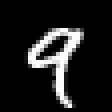

In [86]:
Gray.(reshape(x[:,5], 28, 28)./256)

In [87]:
using Interact

Interact.Options{:SelectionSlider,Any}(17: "input-5" = 50 Any , "i", 50, "50", 50, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(68, "68"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(89, "89"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(85, "85"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(55, "55"),Pair{Any,Any}(42, "42")…)), Any[], Any[], true, "horizontal")

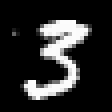

In [88]:
@manipulate for i = 1:100
    Gray.(reshape(x[:,i], 28, 28)./ 256)
end

If we want to, we can also try to visualize the whole dataset at once.

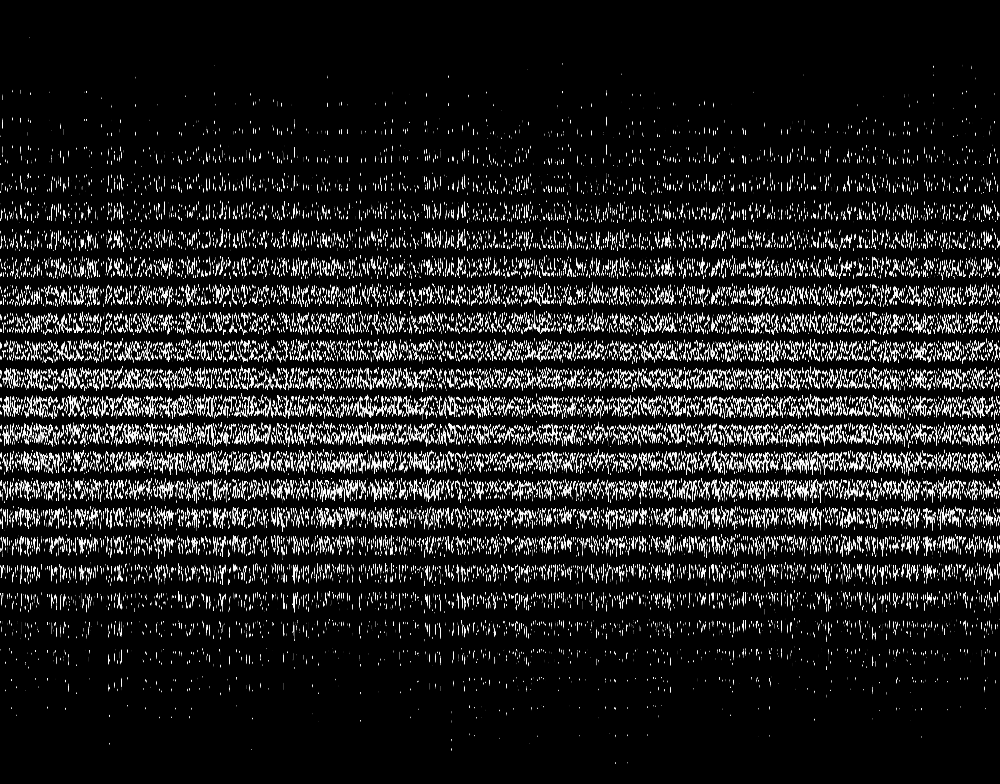

In [89]:
Gray.(x[:, 1:1000]/256)

The target output `y` is a list of digits; you'll recognise the fifth element, `9`, as being the 9 that's drawn above.

In [90]:
y[1:5]

5-element Array{Float64,1}:
 5.0
 0.0
 4.0
 1.0
 9.0

However, this is not a good format for our machine learning model, which needs to predict the probability that an image is any of the ten digits. To do this we put the outputs in "one hot" form, where each column is an image and each row is a given class. For example, the first column represents $5$, so the fifth row is `true`, and so on.

In [91]:
y = Flux.onehotbatch(y, 0:9)

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 false   true  false  false  false  …  false  false  false  false  false
 false  false  false   true  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false   true  false  false  false
 false  false   true  false  false     false  false  false  false  false
  true  false  false  false  false  …  false  false   true  false  false
 false  false  false  false  false     false  false  false   true  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false      true  false  false  false   true
 false  false  false  false   true     false  false  false  false  false

We can also visualise `y` in one-hot form.

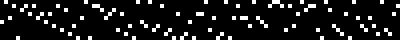

In [92]:
Gray{N0f8}.(y[:,1:100])

Here's our model, a multi-layer perceptron.

In [93]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax)

Chain(Dense(784, 32, NNlib.relu), Dense(32, 10), NNlib.softmax)

Calling the model with our input images `x` gives us a predicted output `y`.

In [94]:
m(x)

Tracked 10×60000 Array{Float64,2}:
 0.0696829  0.119989   0.0712986  …  0.0938659  0.129007   0.0550056
 0.0958511  0.132576   0.0328355     0.199839   0.0509112  0.182999 
 0.0282618  0.0819336  0.190875      0.0247511  0.114418   0.04537  
 0.520201   0.152639   0.196388      0.335171   0.0787793  0.294042 
 0.0182027  0.0317786  0.0209409     0.022003   0.0139034  0.0489937
 0.0284954  0.0790576  0.0678516  …  0.0615409  0.121789   0.0361271
 0.0475947  0.0891527  0.0569869     0.0441147  0.0752837  0.0894989
 0.0719146  0.186923   0.109874      0.098356   0.304084   0.126583 
 0.0569364  0.0840023  0.0774256     0.0757655  0.0480717  0.0302079
 0.0628597  0.0419479  0.175524      0.0445929  0.0637536  0.091172 

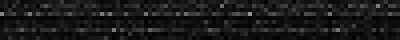

In [95]:
Gray.(m(x).data)[:,1:100]

Compared to the `y` above, our model is assigning low probabilities to every class for every image; it can't make any confident predictions without being trained. Once again we can quantify how far we are off target with a loss function.

In [96]:
loss(x, y) = Flux.mse(m(x), y)
loss(x, y)

Tracked 0-dimensional Array{Float64,0}:
0.0951702

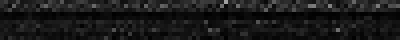

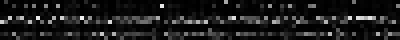

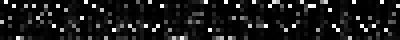

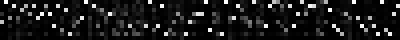

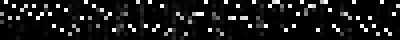

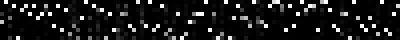

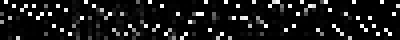

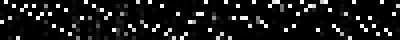

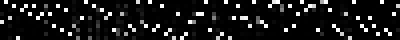

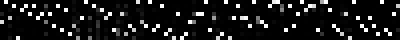

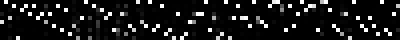

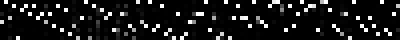

In [97]:
dataset = repeated((x, y), 100)
evalcb = () -> display(Gray.(m(x).data)[:,1:100])
opt = SGD(params(m), 0.1)
Flux.train!(loss, dataset, opt, cb = Flux.throttle(evalcb, 5))

You can easily see the predictions gradually getting more confident, and they're looking very similar to the ground truth.

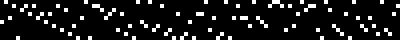

In [98]:
Gray.(y)[:,1:100]

It's obvious that the predicted classes, while noisier, are very close to the true values; our model has learned how to tell a 9 from a 3 and so on. You can dig down to the parts where the model is less confident. For example, we're not sure whether image 34 is a 7 or a 9. Pulling that image out, it's easy to see why.

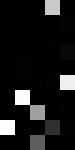

In [59]:
Gray.(m(x).data)[:,32:36]

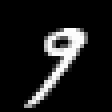

In [60]:
Gray.(reshape(x[:,34], 28, 28)./256)